In [2]:
# Data analysis and wrangling
import pandas as pd
import numpy as np

# Data visualisation
import seaborn as sns
import matplotlib.pyplot as plt

# Dates
import datetime
from matplotlib.dates import DateFormatter

# Text analysis
import nltk
nltk.download('punkt')
from nltk.tokenize import word_tokenize
from nltk.probability import FreqDist 
import re

# Statistical analysis
from scipy.stats import ttest_ind

# Remove warnings
import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\tamer\AppData\Roaming\nltk_data...
[nltk_data]   Unzipping tokenizers\punkt.zip.


In [3]:
purchase_data = pd.read_csv("QVI_purchase_behaviour.csv")
transaction_data = pd.read_excel("QVI_transaction_data.xlsx")

In [4]:
transaction_data.info()
transaction_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 264836 entries, 0 to 264835
Data columns (total 8 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   DATE            264836 non-null  int64  
 1   STORE_NBR       264836 non-null  int64  
 2   LYLTY_CARD_NBR  264836 non-null  int64  
 3   TXN_ID          264836 non-null  int64  
 4   PROD_NBR        264836 non-null  int64  
 5   PROD_NAME       264836 non-null  object 
 6   PROD_QTY        264836 non-null  int64  
 7   TOT_SALES       264836 non-null  float64
dtypes: float64(1), int64(6), object(1)
memory usage: 16.2+ MB


,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES
0,43390,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0
1,43599,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3
2,43605,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9
3,43329,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0
4,43330,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8


In [5]:
purchase_data.info()
purchase_data.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 72637 entries, 0 to 72636
Data columns (total 3 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   LYLTY_CARD_NBR    72637 non-null  int64 
 1   LIFESTAGE         72637 non-null  object
 2   PREMIUM_CUSTOMER  72637 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.7+ MB


,LYLTY_CARD_NBR,LIFESTAGE,PREMIUM_CUSTOMER
0,1000,YOUNG SINGLES/COUPLES,Premium
1,1002,YOUNG SINGLES/COUPLES,Mainstream
2,1003,YOUNG FAMILIES,Budget
3,1004,OLDER SINGLES/COUPLES,Mainstream
4,1005,MIDAGE SINGLES/COUPLES,Mainstream


In [6]:
purchase_data.nunique()

LYLTY_CARD_NBR      72637
LIFESTAGE               7
PREMIUM_CUSTOMER        3
dtype: int64

In [7]:
transaction_data.nunique()

DATE                 364
STORE_NBR            272
LYLTY_CARD_NBR     72637
TXN_ID            263127
PROD_NBR             114
PROD_NAME            114
PROD_QTY               6
TOT_SALES            112
dtype: int64

In [8]:
transaction_data.isnull().sum()

DATE              0
STORE_NBR         0
LYLTY_CARD_NBR    0
TXN_ID            0
PROD_NBR          0
PROD_NAME         0
PROD_QTY          0
TOT_SALES         0
dtype: int64

In [9]:
purchase_data.isnull().sum()

LYLTY_CARD_NBR      0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [10]:
# Date is not in the right format
# Function that converts Excel integer into yyyy-mm-dd format
def date_to_datetime(date):
    excel_anchor = datetime.datetime(1900, 1, 1)
    if(date < 60):
        delta_in_days = datetime.timedelta(days = (date - 1))
    else:
        delta_in_days = datetime.timedelta(days = (date - 2))
    converted_date = excel_anchor + delta_in_days
    return converted_date

# Apply function to Date feature in transactionData dataset
transaction_data['DATE'] = transaction_data['DATE'].apply(date_to_datetime)

In [11]:
transaction_data['DATE']

0        2018-10-17
1        2019-05-14
2        2019-05-20
3        2018-08-17
4        2018-08-18
            ...    
264831   2019-03-09
264832   2018-08-13
264833   2018-11-06
264834   2018-12-27
264835   2018-09-22
Name: DATE, Length: 264836, dtype: datetime64[ns]

In [12]:
# Extract weights out of 'PROD_NAME'

transaction_data['PACK_SIZE'] = transaction_data['PROD_NAME'].str.extract("(\d+)")
transaction_data['PACK_SIZE'] = pd.to_numeric(transaction_data['PACK_SIZE'])
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny SeaSalt175g,2,6.0,175
1,2019-05-14,1,1307,348,66,CCs Nacho Cheese 175g,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken 170g,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S/Cream&Onion 175g,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla ChpsHny&Jlpno Chili 150g,3,13.8,150


In [13]:
# Create text cleaning function for PROD_NAME feature
def clean_text(text):
    text = re.sub('[&/]', ' ', text) # remove special characters '&' and '/'
    text = re.sub('\d\w*', ' ', text) # remove product weights
    return text

# Apply text cleaning function to PROD_NAME column
transaction_data['PROD_NAME'] = transaction_data['PROD_NAME'].apply(clean_text)

In [14]:
# Create one giant string and apply 'word_tokenize' to separate the words

cleanProdName = transaction_data['PROD_NAME']
string = ''.join(cleanProdName)
prodWord = word_tokenize(string)

In [15]:
# Apply 'fdist' function which computes the frequency of each token and put it into a dataframe

wordFrequency = FreqDist(prodWord)
freq_df = pd.DataFrame(list(wordFrequency.items()), 
                       columns = ["Word", "Frequency"]).sort_values(by = 'Frequency', 
                                                                    ascending = False)

# Let's see the top 5 most frequent words
freq_df.head()

,Word,Frequency
10,Chips,49770
16,Kettle,40739
7,Smiths,28572
6,Cheese,27890
66,Pringles,24743


In [16]:
# Drop rows with salsa word in PROD_NAME
transaction_data['PROD_NAME'] =  transaction_data['PROD_NAME'].apply(lambda x: x.lower())
transaction_data =  transaction_data[~ transaction_data['PROD_NAME'].str.contains("salsa")]
transaction_data['PROD_NAME'] =  transaction_data['PROD_NAME'].apply(lambda x: x.title())
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150


In [17]:
# Value counts of PROD_QTY
transaction_data['PROD_QTY'].value_counts()

2      220070
1       25476
5         415
3         408
4         371
200         2
Name: PROD_QTY, dtype: int64

We have two occurences of 200 in the dataset. This seems odd so let's explore further.

In [18]:
transaction_data.loc[transaction_data['PROD_QTY'] == 200]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


Both these transactions have been made by the same person at the same store. Let's see all the transactions this person has made by tracking his loyalty card number.

In [19]:
transaction_data.loc[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE
69762,2018-08-19,226,226000,226201,4,Dorito Corn Chp Supreme,200,650.0,380
69763,2019-05-20,226,226000,226210,4,Dorito Corn Chp Supreme,200,650.0,380


This customer has only made two transactions over the entire year so unlikely to be a retail customer. He/she is most likely purchasing for commercial purposes so it is safe for us to drop these this customer from both 'transactionData' and 'customerData' dataset.

In [20]:
transaction_data.drop(transaction_data.index[transaction_data['LYLTY_CARD_NBR'] == 226000], inplace = True)
purchase_data.drop(purchase_data.index[purchase_data['LYLTY_CARD_NBR'] == 226000], inplace = True)

In [21]:
# Make sure it has been dropped 
transaction_data.loc[transaction_data['LYLTY_CARD_NBR'] == 226000]

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE


In [22]:
# Now let's examine the number of transactions over time to see if there are any obvious data
# issues e.g. missing data
transaction_data['DATE'].nunique()

364

In [23]:
# Look for the missing date 

pd.date_range(start = '2018-07-01', end = '2019-06-30').difference(transaction_data['DATE'])

DatetimeIndex(['2018-12-25'], dtype='datetime64[ns]', freq=None)

We have a missing date on Christmas Day. This makes sense because most retail stores are closed that day.

In [24]:
# Create a new dataframe which contains the total sale for each date
df1 = pd.pivot_table(transaction_data, values = 'TOT_SALES', index = 'DATE', aggfunc = 'sum')
df1.head()

,TOT_SALES
DATE,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [25]:
df2 = pd.DataFrame(index = pd.date_range(start = '2018-07-01', end = '2019-06-30'))
df2['TOT_SALES'] = 0
len(df2)

365

In [26]:
df = df1 + df2
df.fillna(0, inplace = True)
df.head()

,TOT_SALES
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


In [27]:
df.index.name = 'Date'
df.rename(columns = {'TOT_SALES': 'Total Sales'}, inplace = True)
df.head() 

,Total Sales
Date,
2018-07-01,4920.1
2018-07-02,4877.0
2018-07-03,4954.7
2018-07-04,4968.1
2018-07-05,4682.0


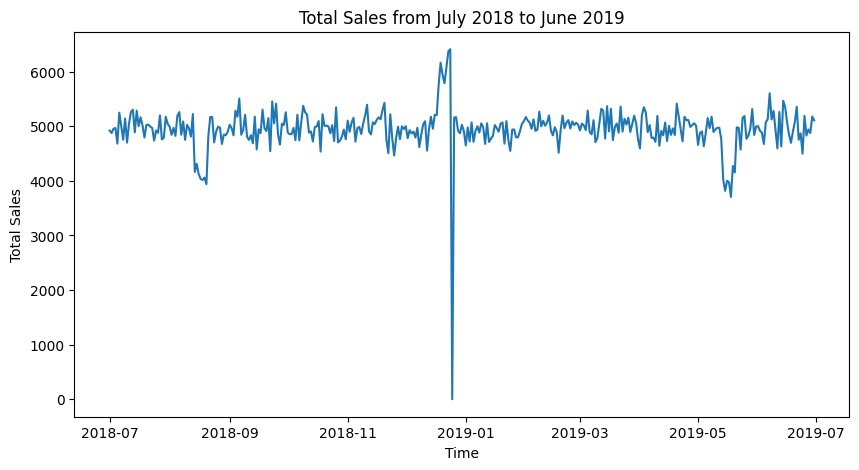

In [28]:
timeline = df.index
graph = df['Total Sales']

fig, ax = plt.subplots(figsize = (10, 5))
ax.plot(timeline, graph)

date_form = DateFormatter("%Y-%m")
ax.xaxis.set_major_formatter(date_form)
plt.title('Total Sales from July 2018 to June 2019')
plt.xlabel('Time')
plt.ylabel('Total Sales')

plt.show()

In [29]:
# Let's look at the December month only

df_december = df[(df.index < "2019-01-01") & (df.index > "2018-11-30")]
df_december.head()

,Total Sales
Date,
2018-12-01,5000.9
2018-12-02,4781.1
2018-12-03,4927.0
2018-12-04,4869.4
2018-12-05,4900.5


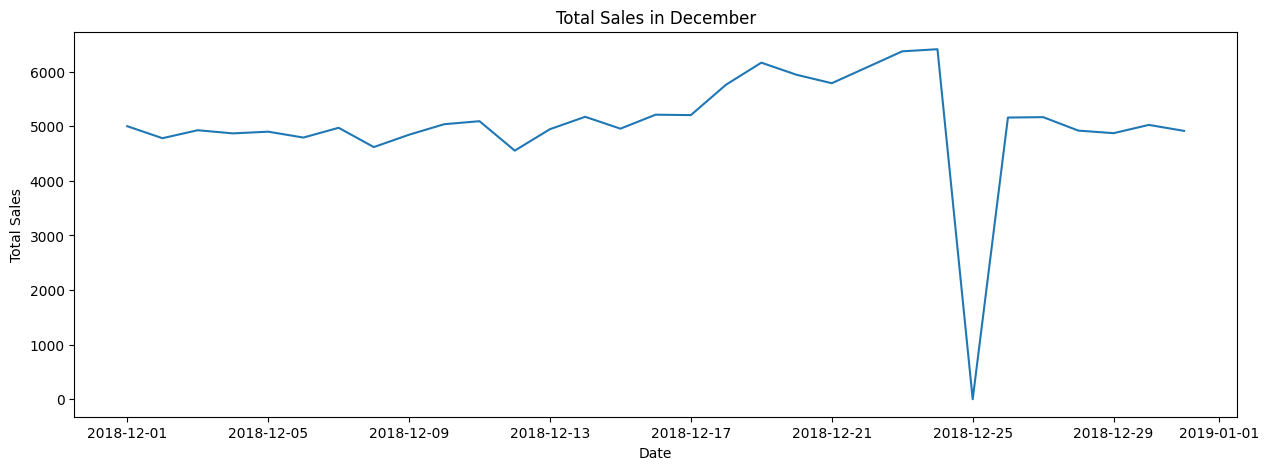

In [30]:
plt.figure(figsize = (15, 5))
plt.plot(df_december)
plt.xlabel('Date')
plt.ylabel('Total Sales')
plt.title('Total Sales in December');

In [31]:
# Reset index
df_december.reset_index(drop = True, inplace = True)

# Relabel Date
df_december['Date'] = df_december.index + 1
df_december.head()

,Total Sales,Date
0,5000.9,1
1,4781.1,2
2,4927.0,3
3,4869.4,4
4,4900.5,5


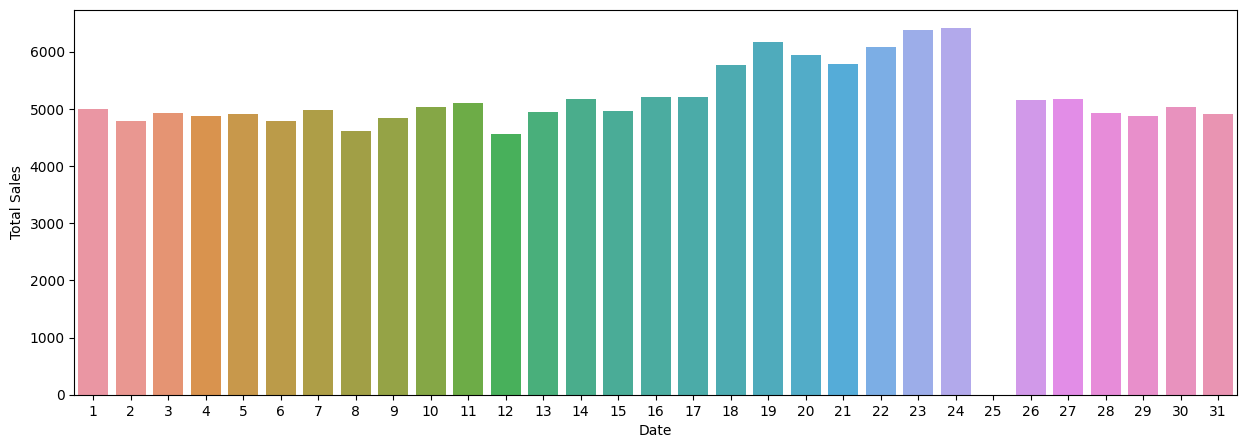

In [32]:
plt.figure(figsize = (15,5))
sns.barplot(x = 'Date', y ='Total Sales', data = df_december);

In [33]:
transaction_data['PACK_SIZE'].unique()

array([175, 170, 150, 330, 210, 270, 220, 125, 110, 134, 380, 180, 165,
       135, 250, 200, 160, 190,  90,  70], dtype=int64)

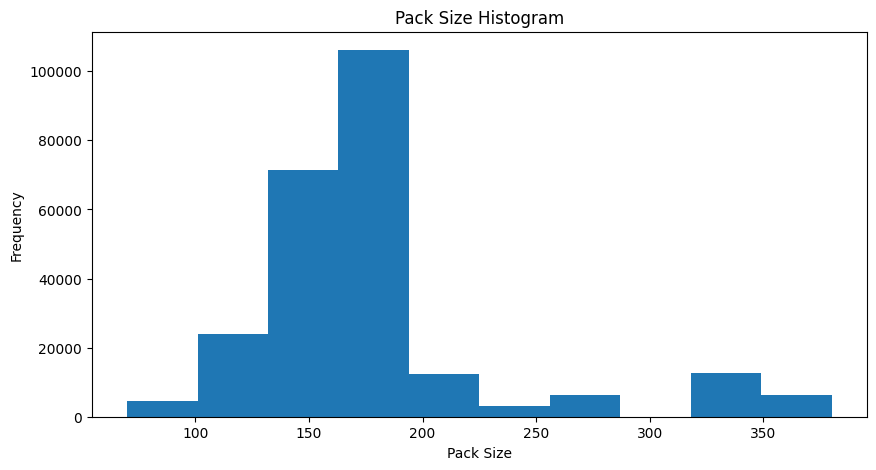

In [34]:
# Check the distribution of PACK_SIZE
plt.figure(figsize = (10, 5))
plt.hist(transaction_data['PACK_SIZE'])     
plt.xlabel('Pack Size')
plt.ylabel('Frequency')
plt.title('Pack Size Histogram');

In [35]:
# Extract brand name from PROD_NAME and create new column called BRAND

brand = transaction_data['PROD_NAME'].str.partition()
transaction_data['BRAND'] = brand[0]
transaction_data.head()

,DATE,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND
0,2018-10-17,1,1000,1,5,Natural Chip Compny Seasalt,2,6.0,175,Natural
1,2019-05-14,1,1307,348,66,Ccs Nacho Cheese,3,6.3,175,Ccs
2,2019-05-20,1,1343,383,61,Smiths Crinkle Cut Chips Chicken,2,2.9,170,Smiths
3,2018-08-17,2,2373,974,69,Smiths Chip Thinly S Cream Onion,5,15.0,175,Smiths
4,2018-08-18,2,2426,1038,108,Kettle Tortilla Chpshny Jlpno Chili,3,13.8,150,Kettle


In [36]:
transaction_data['BRAND'].unique()

array(['Natural', 'Ccs', 'Smiths', 'Kettle', 'Grain', 'Doritos',
       'Twisties', 'Ww', 'Thins', 'Burger', 'Ncc', 'Cheezels', 'Infzns',
       'Red', 'Pringles', 'Dorito', 'Infuzions', 'Smith', 'Grnwves',
       'Tyrrells', 'Cobs', 'French', 'Rrd', 'Tostitos', 'Cheetos',
       'Woolworths', 'Snbts', 'Sunbites'], dtype=object)

In [37]:
# Rename brand names for consistency

transaction_data['BRAND'].replace('Ncc', 'Natural', inplace = True)
transaction_data['BRAND'].replace('Ccs', 'CCS', inplace = True)
transaction_data['BRAND'].replace('Smith', 'Smiths', inplace = True)
transaction_data['BRAND'].replace(['Grain', 'Grnwves'], 'Grainwaves', inplace = True)
transaction_data['BRAND'].replace('Dorito', 'Doritos', inplace = True)
transaction_data['BRAND'].replace('Ww', 'Woolworths', inplace = True)
transaction_data['BRAND'].replace('Infzns', 'Infuzions', inplace = True)
transaction_data['BRAND'].replace(['Red', 'Rrd'], 'Red Rock Deli', inplace = True)
transaction_data['BRAND'].replace('Snbts', 'Sunbites', inplace = True)

transaction_data['BRAND'].unique()

array(['Natural', 'CCS', 'Smiths', 'Kettle', 'Grainwaves', 'Doritos',
       'Twisties', 'Woolworths', 'Thins', 'Burger', 'Cheezels',
       'Infuzions', 'Red Rock Deli', 'Pringles', 'Tyrrells', 'Cobs',
       'French', 'Tostitos', 'Cheetos', 'Sunbites'], dtype=object)

In [38]:
# Which brand had the most sales?
transaction_data.groupby('BRAND').TOT_SALES.sum().sort_values(ascending = False)

BRAND
Kettle           390239.8
Doritos          226329.9
Smiths           217492.0
Pringles         177655.5
Infuzions         99047.6
Thins             88852.5
Red Rock Deli     87607.5
Twisties          81522.1
Tostitos          79789.6
Cobs              70569.8
Tyrrells          51647.4
Grainwaves        51617.2
Natural           42318.0
Woolworths        41059.1
Cheezels          40029.9
CCS               18078.9
Cheetos           16884.5
Sunbites           9676.4
French             7929.0
Burger             6831.0
Name: TOT_SALES, dtype: float64

In [39]:
len(purchase_data)

72636

In [40]:
purchase_data['LYLTY_CARD_NBR'].nunique()

72636

In [41]:
purchase_data['LIFESTAGE'].nunique()

7

In [42]:
purchase_data['LIFESTAGE'].unique()

array(['YOUNG SINGLES/COUPLES', 'YOUNG FAMILIES', 'OLDER SINGLES/COUPLES',
       'MIDAGE SINGLES/COUPLES', 'NEW FAMILIES', 'OLDER FAMILIES',
       'RETIREES'], dtype=object)

In [43]:
# Check value counts for lifestages
purchase_data['LIFESTAGE'].value_counts().sort_values(ascending = False)

RETIREES                  14805
OLDER SINGLES/COUPLES     14609
YOUNG SINGLES/COUPLES     14441
OLDER FAMILIES             9779
YOUNG FAMILIES             9178
MIDAGE SINGLES/COUPLES     7275
NEW FAMILIES               2549
Name: LIFESTAGE, dtype: int64

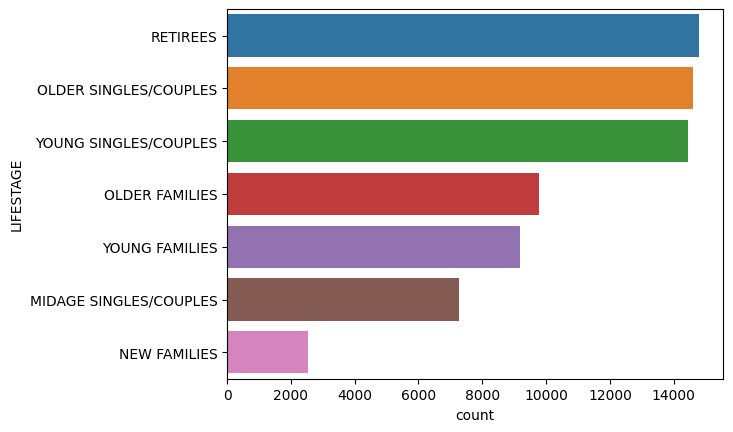

In [44]:
# Ploting the value counts for lifestages:
sns.countplot(y = purchase_data['LIFESTAGE'], order = purchase_data['LIFESTAGE'].value_counts().index);

In [45]:
# Check the unique premium customer categories?
purchase_data['PREMIUM_CUSTOMER'].nunique()

3

In [46]:
# Check value counts for each premium customer category:
purchase_data['PREMIUM_CUSTOMER'].value_counts().sort_values(ascending = False)

Mainstream    29245
Budget        24470
Premium       18921
Name: PREMIUM_CUSTOMER, dtype: int64

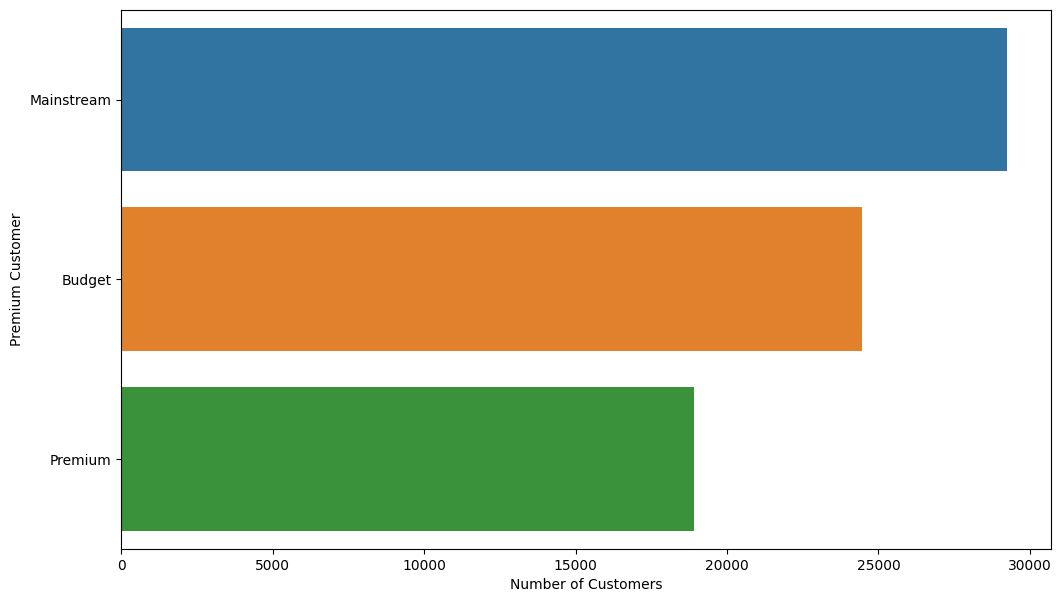

In [47]:
# Ploting the value counts for PREMIUM_CUSTOMER:
plt.figure(figsize = (12, 7))
sns.countplot(y = purchase_data['PREMIUM_CUSTOMER'], order = purchase_data['PREMIUM_CUSTOMER'].value_counts().index)
plt.xlabel('Number of Customers')
plt.ylabel('Premium Customer');

In [48]:
# Merge transaction_data and purchase_data together
df = pd.merge(transaction_data, purchase_data)
df = df.set_index("DATE").sort_index()
df

,STORE_NBR,LYLTY_CARD_NBR,TXN_ID,PROD_NBR,PROD_NAME,PROD_QTY,TOT_SALES,PACK_SIZE,BRAND,LIFESTAGE,PREMIUM_CUSTOMER
DATE,,,,,,,,,,,
2018-07-01,39,39077,35094,104,Infuzions Thai Sweetchili Potatomix,2,7.6,110,Infuzions,MIDAGE SINGLES/COUPLES,Premium
2018-07-01,80,80003,78303,99,Pringles Sthrn Friedchicken,2,7.4,134,Pringles,RETIREES,Mainstream
2018-07-01,93,93176,91792,27,Ww Supreme Cheese Corn Chips,2,3.8,200,Woolworths,OLDER FAMILIES,Mainstream
2018-07-01,125,125227,129193,4,Dorito Corn Chp Supreme,2,13.0,380,Doritos,YOUNG SINGLES/COUPLES,Premium
2018-07-01,147,147123,146450,27,Ww Supreme Cheese Corn Chips,2,3.8,200,Woolworths,YOUNG FAMILIES,Mainstream
...,...,...,...,...,...,...,...,...,...,...,...
2019-06-30,100,100190,99666,10,Rrd Sr Slow Rst Pork Belly,2,5.4,150,Red Rock Deli,OLDER FAMILIES,Mainstream
2019-06-30,230,230102,232603,52,Grain Waves Sour Cream Chives,2,7.2,210,Grainwaves,OLDER SINGLES/COUPLES,Premium
2019-06-30,58,58097,53258,16,Smiths Crinkle Chips Salt Vinegar,2,11.4,330,Smiths,YOUNG SINGLES/COUPLES,Mainstream


In [ ]:
df.to_csv("data.csv")

In [49]:
# Check for null values
df.isnull().sum()

STORE_NBR           0
LYLTY_CARD_NBR      0
TXN_ID              0
PROD_NBR            0
PROD_NAME           0
PROD_QTY            0
TOT_SALES           0
PACK_SIZE           0
BRAND               0
LIFESTAGE           0
PREMIUM_CUSTOMER    0
dtype: int64

In [50]:
# Who spends the most on chips, describing customers by lifestage and how premium their general purchasing behaviour is:
df['SALES'] = df['PROD_QTY'] * df['TOT_SALES']
df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['SALES'].sum().sort_values(ascending=False)

LIFESTAGE               PREMIUM_CUSTOMER
OLDER FAMILIES          Budget              312310.65
YOUNG SINGLES/COUPLES   Mainstream          285417.80
RETIREES                Mainstream          283836.55
YOUNG FAMILIES          Budget              257930.65
OLDER SINGLES/COUPLES   Budget              252142.90
                        Mainstream          245820.40
                        Premium             243783.75
RETIREES                Budget              207732.80
OLDER FAMILIES          Mainstream          192301.25
RETIREES                Premium             179405.35
YOUNG FAMILIES          Mainstream          171925.55
MIDAGE SINGLES/COUPLES  Mainstream          167018.35
YOUNG FAMILIES          Premium             156075.60
OLDER FAMILIES          Premium             150054.30
YOUNG SINGLES/COUPLES   Budget              109479.90
MIDAGE SINGLES/COUPLES  Premium             106859.85
YOUNG SINGLES/COUPLES   Premium              74734.90
MIDAGE SINGLES/COUPLES  Budget           

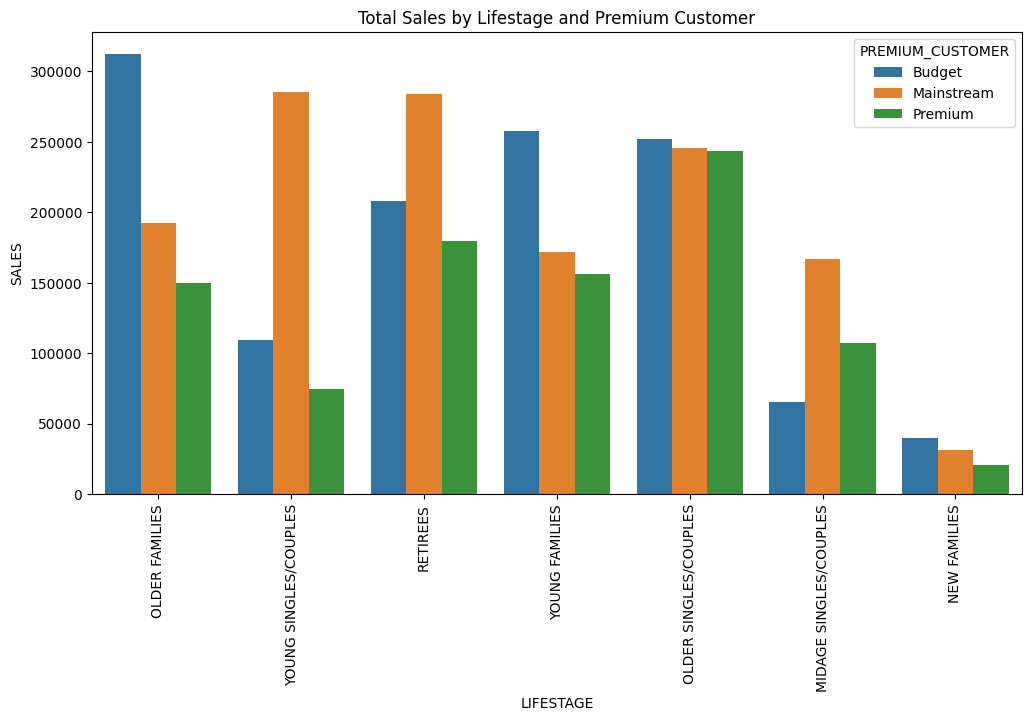

In [51]:
df['SALES'] = df['PROD_QTY'] * df['TOT_SALES']
sales_by_lifestage_premium = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['SALES'].sum().sort_values(ascending=False).reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='SALES', hue='PREMIUM_CUSTOMER', data=sales_by_lifestage_premium)
plt.title('Total Sales by Lifestage and Premium Customer')
plt.xticks(rotation=90)
plt.show()

In [52]:
# How many customers are in each segment:
df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              1474
                        Mainstream          3298
                        Premium             2369
NEW FAMILIES            Budget              1087
                        Mainstream           830
                        Premium              575
OLDER FAMILIES          Budget              4611
                        Mainstream          2788
                        Premium             2231
OLDER SINGLES/COUPLES   Budget              4849
                        Mainstream          4858
                        Premium             4682
RETIREES                Budget              4385
                        Mainstream          6358
                        Premium             3812
YOUNG FAMILIES          Budget              3953
                        Mainstream          2685
                        Premium             2398
YOUNG SINGLES/COUPLES   Budget              3647
                        Main

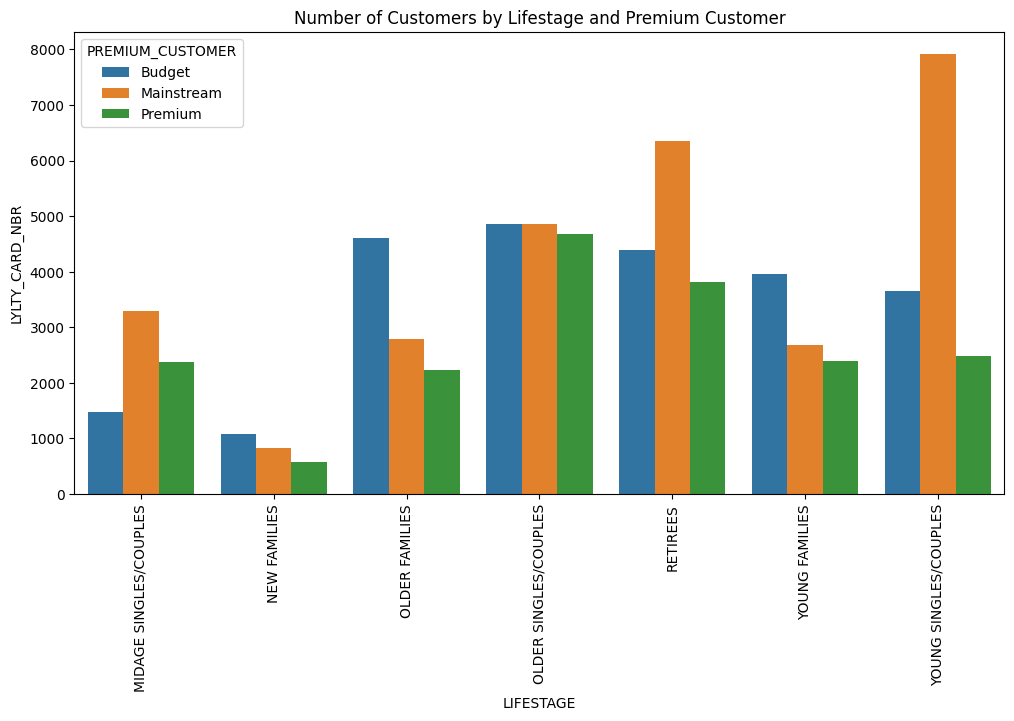

In [53]:
customers_by_lifestage_premium = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique().reset_index()
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='LYLTY_CARD_NBR', hue='PREMIUM_CUSTOMER', data=customers_by_lifestage_premium)
plt.title('Number of Customers by Lifestage and Premium Customer')
plt.xticks(rotation=90)
plt.show()

In [54]:
#How many chips are bought per customer by segment:
df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum() /df.groupby(
    ['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              6.026459
                        Mainstream          6.432080
                        Premium             6.078514
NEW FAMILIES            Budget              4.821527
                        Mainstream          4.891566
                        Premium             4.815652
OLDER FAMILIES          Budget              9.076773
                        Mainstream          9.255380
                        Premium             9.071717
OLDER SINGLES/COUPLES   Budget              6.781398
                        Mainstream          6.712021
                        Premium             6.769543
RETIREES                Budget              6.141847
                        Mainstream          5.925920
                        Premium             6.103358
YOUNG FAMILIES          Budget              8.722995
                        Mainstream          8.638361
                        Premium             8.716013
YOUNG

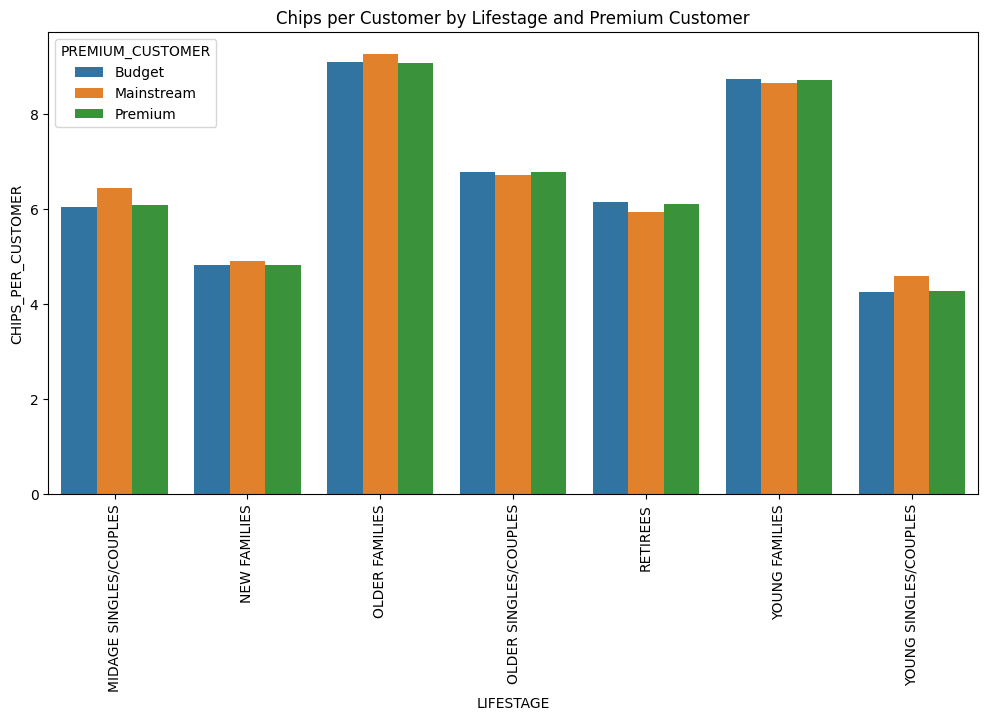

In [55]:
chips_per_customer_by_lifestage_premium = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum() / df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['LYLTY_CARD_NBR'].nunique()
chips_per_customer_by_lifestage_premium = chips_per_customer_by_lifestage_premium.reset_index(name='CHIPS_PER_CUSTOMER')
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='CHIPS_PER_CUSTOMER', hue='PREMIUM_CUSTOMER', data=chips_per_customer_by_lifestage_premium)
plt.title('Chips per Customer by Lifestage and Premium Customer')
plt.xticks(rotation=90)
plt.show()

In [56]:
# What is the average chip price by customer segment:
df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].mean() / df.groupby([
    'LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum()

LIFESTAGE               PREMIUM_CUSTOMER
MIDAGE SINGLES/COUPLES  Budget              0.000800
                        Mainstream          0.000360
                        Premium             0.000497
NEW FAMILIES            Budget              0.001392
                        Mainstream          0.001801
                        Premium             0.002612
OLDER FAMILIES          Budget              0.000174
                        Mainstream          0.000282
                        Premium             0.000357
OLDER SINGLES/COUPLES   Budget              0.000226
                        Mainstream          0.000224
                        Premium             0.000235
RETIREES                Budget              0.000276
                        Mainstream          0.000193
                        Premium             0.000321
YOUNG FAMILIES          Budget              0.000212
                        Mainstream          0.000312
                        Premium             0.000349
YOUNG

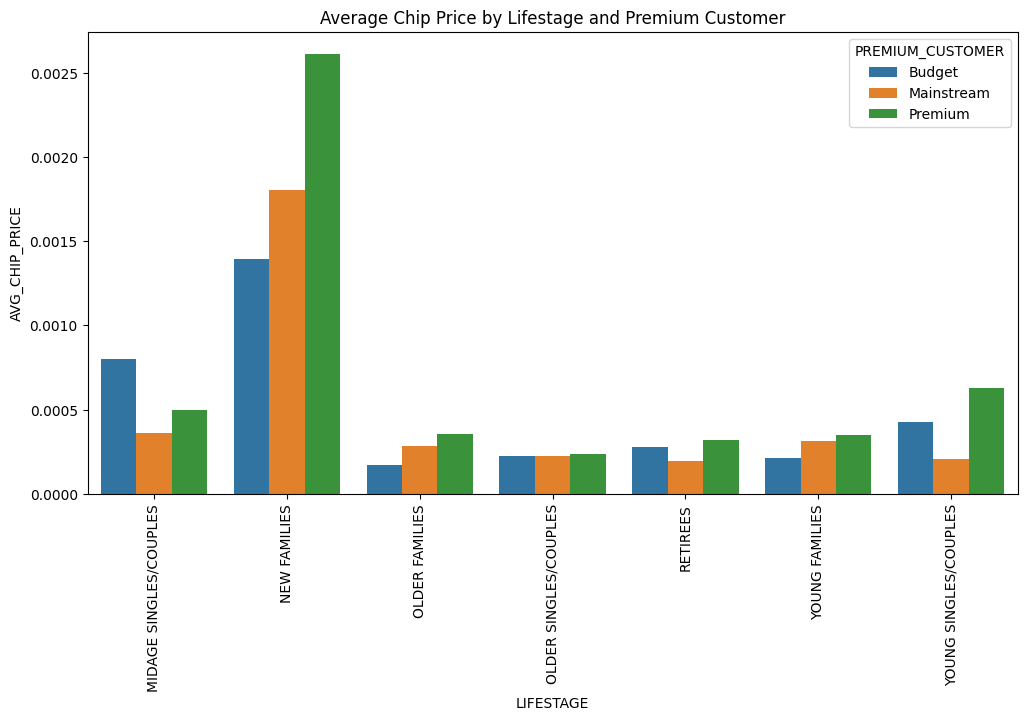

In [57]:
avg_chip_price_by_lifestage_premium = df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['TOT_SALES'].mean() / df.groupby(['LIFESTAGE', 'PREMIUM_CUSTOMER'])['PROD_QTY'].sum()
avg_chip_price_by_lifestage_premium = avg_chip_price_by_lifestage_premium.reset_index(name='AVG_CHIP_PRICE')
plt.figure(figsize=(12, 6))
sns.barplot(x='LIFESTAGE', y='AVG_CHIP_PRICE', hue='PREMIUM_CUSTOMER', data=avg_chip_price_by_lifestage_premium)
plt.title('Average Chip Price by Lifestage and Premium Customer')
plt.xticks(rotation=90)
plt.show()

Summary of the findings:
- Mainstream young singles/couples are the largest customer segment in terms of total sales.
- Mainstream, young singles/couples are also the largest customer segment in terms of population.
- Budget - older families have the highest average price per packet of chips and spend more on chips than their premium counterparts.
- Mainstream - young singles/couples have the highest average number of chips bought per customer.
- Mainstream - retirees have the lowest average number of chips bought per customer and also spend the least on chips.
- Chips with a price point of 2.6 dollars have the highest sales across all customer segments.